### Import Packages


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import random

### Global attributes

In [2]:
training_dataroot = 'processed_data_weekday.csv'
testing_dataroot = 'processed_data_weekday_test.csv'
output_dataroot = 'lab1_basic.csv' 

training_datalist =  [] 
testing_datalist =  [] # Testing datalist, saved as numpy array

output_datalist =  [] 

Process data-> turn the date into weekday

In [ ]:
import pandas as pd

df = pd.read_csv(testing_dataroot)
df['upload time'] = pd.to_datetime(df['upload time'])
df['day_of_week'] = df['upload time'].dt.dayofweek
df = pd.get_dummies(df, columns=['day_of_week'], prefix='day')
df['hashtag_count'] = df['hashtag'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

df.to_csv('processed_data_weekday_test.csv', index=False)

print(df)


      Post Index  followers         upload time  Like Count  Comment Count  \
0              0    1539000 2024-11-18 09:42:12    336000.0            276   
1              1    4647000 2024-11-22 08:34:18    769000.0            114   
2              2    1113000 2024-11-23 14:50:50     85000.0            152   
3              3     221000 2024-11-22 11:38:19     31000.0            183   
4              4    9111000 2024-11-22 10:02:55    435000.0            157   
...          ...        ...                 ...         ...            ...   
3177         963      60000 2024-11-25 00:28:51         2.0              2   
3178         964     173000 2024-10-04 13:10:35     15000.0             29   
3179         965      28000 2024-11-08 15:29:04      6447.0             28   
3180         966      40000 2024-11-14 08:47:15     10000.0              3   
3181         967     159000 2024-11-13 10:32:49      2385.0              6   

      is Photo  is Video                                       

### Load the Input File

In [3]:
# Read input csv to datalist
with open(training_dataroot, newline='') as csvfile:
  training_datalist = pd.read_csv(training_dataroot)

with open(testing_dataroot, newline='') as csvfile:
  testing_datalist = pd.read_csv(testing_dataroot)
  testing_datalist=testing_datalist[testing_datalist['is Photo'] == 1]


In [ ]:
print(testing_datalist.shape)

(1865, 20)


### Implement the Regression Model

### Process Hashtag

In [4]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # remove all the punctuation marks but leave the emoji
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') which is to remove the noise of emoji
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

nltk.download('stopwords')
stop = stopwords.words('english')
# conbined groups with similar properties, such as same verb with different tense
def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]
count = CountVectorizer(ngram_range=(1, 1),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)
#build the hashtag matrix transformer
count.fit(training_datalist["hashtag"].to_numpy())
BoW = count.vocabulary_
#print what kind of vocabulary inside
print('[vocabulary]\n{}'.format(BoW))

#transform the training dataset
doc_bag = count.transform(training_datalist["hashtag"].to_numpy())
doc_bag = doc_bag.toarray()
print(doc_bag)

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
C:\Users\sammy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[vocabulary]
{'polarbear': 6594, 'icecream': 3785, 'aiart': 150, 'artcommun': 437, 'cub': 1851, 'cutebear': 1884, 'art': 432, 'polar': 6593, 'arctic': 405, 'ice': 3782, 'cream': 1818, 'crispi': 1836, 'fri': 2886, 'chicken': 1447, 'chop': 1498, 'shrimp': 7589, 'hualien': 3689, 'citi': 1548, 'food': 2810, 'simpl': 7635, 'lunch': 5043, 'dinner': 2123, 'eat': 2342, 'great': 3196, 'heart': 3532, 'picnic': 6491, 'pine': 6509, 'garden': 2977, 'annex': 325, 'gourmet': 3168, 'ingredi': 3895, 'caus': 1329, 'stalk': 7932, 'oblint': 6152, 'mag': 5086, 'meme': 5333, 'share': 7508, 'joke': 4212, 'sneer': 7734, 'funni': 2917, 'movi': 5705, 'humor': 3716, 'quotat': 6838, 'chang': 1384, 'lu': 5028, 'guangzhong': 3242, 'singer': 7643, 'muscl': 5760, 'fit': 2763, 'snack': 7729, 'afternoon': 117, 'tea': 8280, 'fux': 2937, 'street': 8015, 'stone': 7990, 'cake': 1190, 'famili': 2629, 'girn': 3083, 'hualienfood': 3691, 'hashtag': 3499, 'girhein': 3066, 'geoentertain': 3022, 'harpalgeo': 3491, 'geotv': 3028, 

Preprocess and split the data

In [5]:
# to make the data with big value to take the logarithm
def preProcessed(x, y):
    x = x.astype(np.float64) 
    y = y.astype(np.float64)
    y = y[:, np.newaxis]
    combined = np.hstack((x, y))
    nan_removed = combined[~np.isnan(combined).any(axis=1)]
    x_train = nan_removed[:, :-1]
    y_train = nan_removed[:, -1:]
    x_train[:, 0] = np.where(x_train[:, 0] > 0, np.log10(x_train[:, 0].clip(min=1e-10)), x_train[:, 0])
    y_train[:, 0] = np.where(y_train[:, 0] > 0, np.log10(y_train[:, 0].clip(min=1e-10)), y_train[:, 0])
    return x_train, y_train

#split data for validation
def split_data(X_train, Y_train, split_ratio=0.2):

    x_split_size = int(len(X_train) * split_ratio)
    y_split_size = int(len(Y_train) * split_ratio)
    x_train = X_train[x_split_size:]
    y_train = Y_train[y_split_size:]
    x_val = X_train[:x_split_size]
    y_val = Y_train[:y_split_size]

    return x_train, y_train, x_val, y_val

Pick up the features

In [6]:
#pick up the feature we need("followers", "is Photo" ,"hashtag_count") and stack the data with weekday  matrix and hashtag matrix
xy = training_datalist[["followers", "is Photo" ,"hashtag_count","Like Count"]].to_numpy()
weekday=training_datalist[["day_0", "day_1","day_2","day_3","day_4","day_5","day_6"]].to_numpy()
print(xy)
x = xy[:, :-1]
x= np.hstack((x,weekday))  
x= np.hstack((x,doc_bag))
y = xy[:, -1]   
print(y)
x_processed, y_processed = preProcessed(x, y)
print(y_processed)


[[6.670e+05 0.000e+00 1.000e+01 3.141e+06]
 [1.300e+04 0.000e+00 1.300e+01 2.030e+02]
 [1.200e+04 1.000e+00 1.600e+01 6.817e+03]
 ...
 [3.130e+02 1.000e+00 1.000e+00 1.000e+00]
 [2.500e+01 1.000e+00 1.000e+00 2.000e+00]
 [9.000e+00 1.000e+00 1.000e+00 3.000e+00]]
[3.141e+06 2.030e+02 6.817e+03 ... 1.000e+00 2.000e+00 3.000e+00]
[[6.49706794]
 [2.30749604]
 [3.83359329]
 ...
 [0.        ]
 [0.30103   ]
 [0.47712125]]


stack xy again to split the data by value interval of the followers

In [7]:
xy_processed= np.hstack((x_processed,y_processed)) 

In [8]:
xy_processed_photo=xy_processed[xy_processed[:,1] == 1]
xy_processed_video=xy_processed[xy_processed[:,1] == 0]

In [11]:
td_pic=xy_processed_photo
td_vid=xy_processed_video

In [12]:
td_pic_try1 = []
for i in range(3, 6):
    td_pic_try1.append(td_pic[td_pic[:, 0] > i])
    td_pic_try1[len(td_pic_try1) - 1] = td_pic_try1[len(td_pic_try1) - 1][td_pic_try1[len(td_pic_try1) - 1][:, 0] <= (i+1)]
    # print(len(td_pic_try1[len(td_pic_try1) - 1]))

td_pic_try2 = []
for i in range(2, 5):
    td_pic_try2.append(td_pic[td_pic[:, 0] > i])
    td_pic_try2[len(td_pic_try2) - 1] = td_pic_try2[len(td_pic_try2) - 1][td_pic_try2[len(td_pic_try2) - 1][:, 0] <= (i+2)]
    # print(len(td_pic_try2[len(td_pic_try2) - 1]))

td_pic_try3 = []
for i in range(1, 4):
    td_pic_try3.append(td_pic[td_pic[:, 0] > i])
    td_pic_try3[len(td_pic_try3) - 1] = td_pic_try3[len(td_pic_try3) - 1][td_pic_try3[len(td_pic_try3) - 1][:, 0] <= (i+3)]
    # print(len(td_pic_try3[len(td_pic_try3) - 1]))

td_pic_try1_5 = []
for i in range(3, 6):
    td_pic_try1_5.append(td_pic[td_pic[:, 0] > (i-0.5)])
    td_pic_try1_5[len(td_pic_try1_5) - 1] = td_pic_try1_5[len(td_pic_try1_5) - 1][td_pic_try1_5[len(td_pic_try1_5) - 1][:, 0] <= (i+0.5)]
    # print(len(td_pic_try1_5[len(td_pic_try1_5) - 1]))

td_pic_try2_5 = []
for i in range(2, 5):
    td_pic_try2_5.append(td_pic[td_pic[:, 0] > (i-0.5)])
    td_pic_try2_5[len(td_pic_try2_5) - 1] = td_pic_try2_5[len(td_pic_try2_5) - 1][td_pic_try2_5[len(td_pic_try2_5) - 1][:, 0] <= (i+1.5)]
    # print(len(td_pic_try2_5[len(td_pic_try2_5) - 1]))

td_pic_try3_5 = []
for i in range(1, 4):
    td_pic_try3_5.append(td_pic[td_pic[:, 0] > (i-0.5)])
    td_pic_try3_5[len(td_pic_try3_5) - 1] = td_pic_try3_5[len(td_pic_try3_5) - 1][td_pic_try3_5[len(td_pic_try3_5) - 1][:, 0] <= (i+2.5)]
    # print(len(td_pic_try3_5[len(td_pic_try3_5) - 1]))

td_pic_try = td_pic_try1 + td_pic_try2 + td_pic_try3 + td_pic_try1_5 + td_pic_try2_5 + td_pic_try3_5
print("pic lengths: ")
for i in range(len(td_pic_try)):
    print(len(td_pic_try[i]), end = ", ")
    if i % 6 == 5:
        print()

td_vid_try1 = []
for i in range(3, 6):
    td_vid_try1.append(td_vid[td_vid[:, 0] > i])
    td_vid_try1[len(td_vid_try1) - 1] = td_vid_try1[len(td_vid_try1) - 1][td_vid_try1[len(td_vid_try1) - 1][:, 0] <= (i+1)]
    # print(len(td_vid_try1[len(td_vid_try1) - 1]))

td_vid_try2 = []
for i in range(2, 5):
    td_vid_try2.append(td_vid[td_vid[:, 0] > i])
    td_vid_try2[len(td_vid_try2) - 1] = td_vid_try2[len(td_vid_try2) - 1][td_vid_try2[len(td_vid_try2) - 1][:, 0] <= (i+2)]
    # print(len(td_vid_try2[len(td_vid_try2) - 1]))

td_vid_try3 = []
for i in range(1, 4):
    td_vid_try3.append(td_vid[td_vid[:, 0] > i])
    td_vid_try3[len(td_vid_try3) - 1] = td_vid_try3[len(td_vid_try3) - 1][td_vid_try3[len(td_vid_try3) - 1][:, 0] <= (i+3)]
    # print(len(td_vid_try3[len(td_vid_try3) - 1]))

td_vid_try1_5 = []
for i in range(3, 6):
    td_vid_try1_5.append(td_vid[td_vid[:, 0] > (i-0.5)])
    td_vid_try1_5[len(td_vid_try1_5) - 1] = td_vid_try1_5[len(td_vid_try1_5) - 1][td_vid_try1_5[len(td_vid_try1_5) - 1][:, 0] <= (i+0.5)]
    # print(len(td_vid_try1_5[len(td_vid_try1_5) - 1]))

td_vid_try2_5 = []
for i in range(2, 5):
    td_vid_try2_5.append(td_vid[td_vid[:, 0] > (i-0.5)])
    td_vid_try2_5[len(td_vid_try2_5) - 1] = td_vid_try2_5[len(td_vid_try2_5) - 1][td_vid_try2_5[len(td_vid_try2_5) - 1][:, 0] <= (i+1.5)]
    # print(len(td_vid_try2_5[len(td_vid_try2_5) - 1]))

td_vid_try3_5 = []
for i in range(1, 4):
    td_vid_try3_5.append(td_vid[td_vid[:, 0] > (i-0.5)])
    td_vid_try3_5[len(td_vid_try3_5) - 1] = td_vid_try3_5[len(td_vid_try3_5) - 1][td_vid_try3_5[len(td_vid_try3_5) - 1][:, 0] <= (i+2.5)]
    # print(len(td_vid_try3_5[len(td_vid_try3_5) - 1]))

td_vid_try = td_vid_try1 + td_vid_try2 + td_vid_try3 + td_vid_try1_5 + td_vid_try2_5 + td_vid_try3_5
print("vid lengths: ")
for i in range(len(td_vid_try)):
    print(len(td_vid_try[i]), end = ", ")
    if i % 6 == 5:
        print()

pic lengths: 
176, 1147, 817, 615, 1323, 1964, 
1180, 1762, 2140, 240, 699, 1172, 
775, 939, 1871, 1276, 1474, 2111, 
vid lengths: 
340, 1037, 1196, 1104, 1377, 2233, 
2031, 2141, 2573, 428, 689, 1355, 
1392, 1117, 2044, 2117, 2081, 2472, 


In [13]:
pic_cnt = 0
vid_cnt = 0
pic_MAPEs = []
vid_MAPEs = []

To evalute our model

In [14]:
def MAPE(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE) between the true and predicted values.

    Parameters:
    - y_true (numpy.ndarray): Actual values (ground truth).
    - y_pred (numpy.ndarray): Predicted values.

    Returns:
    - float: MAPE value as a percentage.
    """

    non_zero_indices = y_true != 0
    y_true_filtered = y_true[non_zero_indices]
    y_pred_filtered = y_pred[non_zero_indices]

    ape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

    return ape

Train the catboost model of those date whose post is picture first.
We will train models for different interval and get the MAPE of each model

In [15]:
from catboost import CatBoostRegressor
for i in range(len(td_pic_try)):
    model = CatBoostRegressor(
        iterations=2000,             
        learning_rate=0.001,          
        depth=10,                    
        loss_function='RMSE',       
        random_seed=42,             
        verbose=100                 
    )
    x_process=td_pic_try[i][:,:-1]
    y_process=td_pic_try[i][:,-1]
    x_train, y_train, x_val, y_val = split_data(x_process, y_process, split_ratio=0.2)

    y_train = y_train.ravel()
    y_val = y_val.ravel()
    cat_features = [1] 
    model.fit(
        x_train, y_train,
        eval_set=(x_val, y_val),
        use_best_model=True
    )
    y_pred = model.predict(x_val)

    mape = MAPE(y_val, y_pred)
    print(f"MAPE on validation data: {mape}%")
    pic_MAPEs.append(mape)


0:	learn: 1.2905092	test: 0.9892531	best: 0.9892531 (0)	total: 145ms	remaining: 4m 48s
100:	learn: 1.2379413	test: 1.0078632	best: 0.9889040 (2)	total: 1.03s	remaining: 19.4s
200:	learn: 1.1907403	test: 1.0234206	best: 0.9889040 (2)	total: 1.92s	remaining: 17.2s
300:	learn: 1.1468290	test: 1.0411906	best: 0.9889040 (2)	total: 2.75s	remaining: 15.5s
400:	learn: 1.1071904	test: 1.0570607	best: 0.9889040 (2)	total: 3.63s	remaining: 14.5s
500:	learn: 1.0706384	test: 1.0714608	best: 0.9889040 (2)	total: 4.55s	remaining: 13.6s
600:	learn: 1.0376473	test: 1.0869798	best: 0.9889040 (2)	total: 5.5s	remaining: 12.8s
700:	learn: 1.0059971	test: 1.1017673	best: 0.9889040 (2)	total: 6.43s	remaining: 11.9s
800:	learn: 0.9775479	test: 1.1134548	best: 0.9889040 (2)	total: 7.41s	remaining: 11.1s
900:	learn: 0.9510751	test: 1.1259962	best: 0.9889040 (2)	total: 8.33s	remaining: 10.2s
1000:	learn: 0.9258763	test: 1.1357725	best: 0.9889040 (2)	total: 9.28s	remaining: 9.26s
1100:	learn: 0.9030597	test: 1.14

Then train the catboost model of those date whose post is video.
We will train models for different interval and get the MAPE of each model.

In [16]:
for i in range(len(td_vid_try)):
    model = CatBoostRegressor(
        iterations=2000,             
        learning_rate=0.001,          
        depth=10,                    
        loss_function='RMSE',       
        random_seed=42,             
        verbose=100                 
    )
    x_process=td_vid_try[i][:,:-1]
    y_process=td_vid_try[i][:,-1]
    x_train, y_train, x_val, y_val = split_data(x_process, y_process, split_ratio=0.2)

    y_train = y_train.ravel()
    y_val = y_val.ravel()
    
    model.fit(
        x_train, y_train,
        eval_set=(x_val, y_val),
        use_best_model=True
    )
    y_pred = model.predict(x_val)

    mape = MAPE(y_val, y_pred)
    print(f"MAPE on validation data: {mape}%")
    vid_MAPEs.append(mape)

0:	learn: 1.2568652	test: 1.4146610	best: 1.4146610 (0)	total: 8.7ms	remaining: 17.4s
100:	learn: 1.2281013	test: 1.4128437	best: 1.4127979 (94)	total: 1.69s	remaining: 31.7s
200:	learn: 1.2016866	test: 1.4116195	best: 1.4116136 (194)	total: 3.35s	remaining: 30s
300:	learn: 1.1764581	test: 1.4116930	best: 1.4108258 (226)	total: 5.04s	remaining: 28.5s
400:	learn: 1.1533829	test: 1.4123374	best: 1.4108258 (226)	total: 6.67s	remaining: 26.6s
500:	learn: 1.1322407	test: 1.4125675	best: 1.4108258 (226)	total: 8.22s	remaining: 24.6s
600:	learn: 1.1114322	test: 1.4123437	best: 1.4108258 (226)	total: 9.98s	remaining: 23.2s
700:	learn: 1.0927419	test: 1.4119516	best: 1.4108258 (226)	total: 11.5s	remaining: 21.3s
800:	learn: 1.0758114	test: 1.4119745	best: 1.4108258 (226)	total: 13.1s	remaining: 19.6s
900:	learn: 1.0600094	test: 1.4123517	best: 1.4108258 (226)	total: 14.7s	remaining: 18s
1000:	learn: 1.0447545	test: 1.4129353	best: 1.4108258 (226)	total: 16.3s	remaining: 16.2s
1100:	learn: 1.030

The min MAPE between models for different interval

In [17]:
print(min(pic_MAPEs))
print(min(vid_MAPEs))

16.57858129619087
41.24507175131848


Visualize the MAPE of each model 

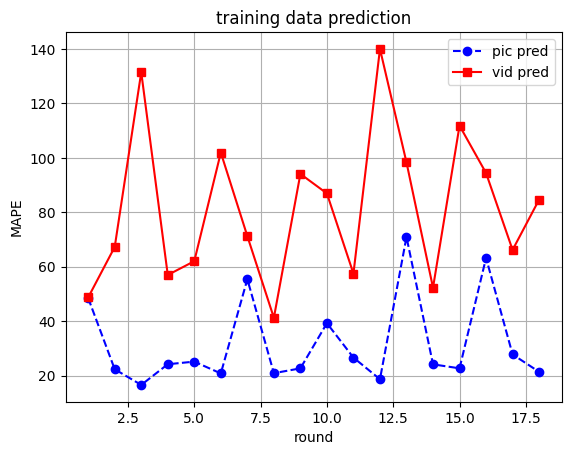

In [18]:
x = []
for i in range(len(td_pic_try)):
    x.append(i+1)
y1 = pic_MAPEs
y2 = vid_MAPEs

plt.plot(x, y1, linestyle='--', marker='o', color='b', label='pic pred')
plt.plot(x, y2, linestyle='-', marker='s', color='r', label='vid pred')

plt.xlabel('round')
plt.ylabel('MAPE')
plt.title("training data prediction")
plt.legend()

plt.grid(True)
plt.show()

Train the catboost model of those date whose post is picture without partitioning

In [9]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error



model = CatBoostRegressor(
    iterations=2000,            
    learning_rate=0.001,          
    depth=10,                   
    loss_function='RMSE',       
    random_seed=42,             
    verbose=100                 
)

xy_processed_photo=xy_processed[xy_processed[:,1] == 1]

x_process=xy_processed_photo[:,:-1]
y_process=xy_processed_photo[:,-1]
x_train_pic, y_train_pic, x_val_pic, y_val_pic = split_data(x_process, y_process, split_ratio=0.2)

x_train_pic[:, 1] = x_train_pic[:, 1].astype(int)

y_train_pic = y_train_pic.ravel()  
y_val_pic = y_val_pic.ravel()

cat_features = [1] 
model.fit(
    x_train_pic, y_train_pic,
    eval_set=(x_val_pic, y_val_pic),
    use_best_model=True
)

y_pred_pic = model.predict(x_val_pic)

mse = mean_squared_error(y_val_pic, y_pred_pic)
print(f"Validation MSE: {mse:.4f}")


0:	learn: 1.4309330	test: 1.3297664	best: 1.3297664 (0)	total: 147ms	remaining: 4m 54s
100:	learn: 1.3719293	test: 1.2587973	best: 1.2587973 (100)	total: 4.25s	remaining: 1m 19s
200:	learn: 1.3200525	test: 1.1957258	best: 1.1957258 (200)	total: 8.28s	remaining: 1m 14s
300:	learn: 1.2751019	test: 1.1397345	best: 1.1397345 (300)	total: 12.5s	remaining: 1m 10s
400:	learn: 1.2356612	test: 1.0907177	best: 1.0907177 (400)	total: 16.5s	remaining: 1m 5s
500:	learn: 1.2012955	test: 1.0479416	best: 1.0479416 (500)	total: 20.6s	remaining: 1m 1s
600:	learn: 1.1707811	test: 1.0102336	best: 1.0102336 (600)	total: 24.8s	remaining: 57.8s
700:	learn: 1.1444578	test: 0.9775108	best: 0.9775108 (700)	total: 28.9s	remaining: 53.6s
800:	learn: 1.1209209	test: 0.9494503	best: 0.9494503 (800)	total: 33s	remaining: 49.4s
900:	learn: 1.0996295	test: 0.9242548	best: 0.9242548 (900)	total: 37.2s	remaining: 45.4s
1000:	learn: 1.0814560	test: 0.9028436	best: 0.9028436 (1000)	total: 41.4s	remaining: 41.3s
1100:	lear

Evaluate the model

In [10]:
def MAPE(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE) between the true and predicted values.

    Parameters:
    - y_true (numpy.ndarray): Actual values (ground truth).
    - y_pred (numpy.ndarray): Predicted values.

    Returns:
    - float: MAPE value as a percentage.
    """

    non_zero_indices = y_true != 0
    y_true_filtered = y_true[non_zero_indices]
    y_pred_filtered = y_pred[non_zero_indices]

    ape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

    return ape

mape = MAPE(y_val_pic, y_pred_pic)
print(f"MAPE on validation data: {mape}%")



MAPE on validation data: 20.182376196594724%


Perfoemance on testing data

In [11]:
print(testing_datalist.shape)
doc_bag_test = count.transform(testing_datalist["hashtag"].to_numpy())
doc_bag_test = doc_bag_test.toarray()
print(doc_bag_test.shape)
xy_test = testing_datalist[["followers", "is Photo" ,"hashtag_count","Like Count"]].to_numpy()
weekday_test=testing_datalist[["day_0", "day_1","day_2","day_3","day_4","day_5","day_6"]].to_numpy()
print()
x_test = xy_test[:, :-1]
x_test= np.hstack((x_test,weekday_test))  
x_test= np.hstack((x_test,doc_bag_test))
y_test = xy_test[:, -1]   
x_test, y_test = preProcessed(x_test, y_test)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
y_pred_test = model.predict(x_test)
print(y_pred_test.shape)
y_test = y_test.ravel()
mape = MAPE(y_test, y_pred_test)
print(f"MAPE on test data: {mape}%")


(1865, 27)
(1865, 9590)

x_test shape: (1840, 9600), y_test shape: (1840, 1)
(1840,)
MAPE on test data: 31.655792109681176%


Train the catboost model of those date whose post is video without partitioning.

In [12]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error



model_vid = CatBoostRegressor(
    iterations=2000,            
    learning_rate=0.001,          
    depth=10,                   
    loss_function='RMSE',       
    random_seed=42,             
    verbose=100                 
)


x_process=xy_processed_video[:,:-1]
y_process=xy_processed_video[:,-1]
x_train_vid, y_train_vid, x_val_vid, y_val_vid = split_data(x_process, y_process, split_ratio=0.2)

x_train_vid[:, 1] = x_train_vid[:, 1].astype(int)

y_train_vid = y_train_vid.ravel()  
y_val_vid = y_val_vid.ravel()

cat_features = [1] 
model_vid.fit(
    x_train_vid, y_train_vid,
    eval_set=(x_val_vid, y_val_vid),
    use_best_model=True
)

y_pred_vid = model_vid.predict(x_val_vid)

mse = mean_squared_error(y_val_vid, y_pred_vid)
print(f"Validation MSE: {mse:.4f}")

0:	learn: 1.8499900	test: 1.7763843	best: 1.7763843 (0)	total: 24.9ms	remaining: 49.7s
100:	learn: 1.7456248	test: 1.6691147	best: 1.6691147 (100)	total: 5.38s	remaining: 1m 41s
200:	learn: 1.6546792	test: 1.5780547	best: 1.5780547 (200)	total: 10.8s	remaining: 1m 37s
300:	learn: 1.5755861	test: 1.5021302	best: 1.5021302 (300)	total: 16.2s	remaining: 1m 31s
400:	learn: 1.5070480	test: 1.4396241	best: 1.4396241 (400)	total: 21.5s	remaining: 1m 25s
500:	learn: 1.4476208	test: 1.3883233	best: 1.3883233 (500)	total: 26.9s	remaining: 1m 20s
600:	learn: 1.3962621	test: 1.3466209	best: 1.3466209 (600)	total: 32.2s	remaining: 1m 14s
700:	learn: 1.3510989	test: 1.3133990	best: 1.3133990 (700)	total: 37.7s	remaining: 1m 9s
800:	learn: 1.3115258	test: 1.2862936	best: 1.2862936 (800)	total: 43.1s	remaining: 1m 4s
900:	learn: 1.2778744	test: 1.2655324	best: 1.2655324 (900)	total: 48.5s	remaining: 59.2s
1000:	learn: 1.2480832	test: 1.2496117	best: 1.2496117 (1000)	total: 54.1s	remaining: 54s
1100:	l

evaluate the model

In [13]:
def MAPE(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE) between the true and predicted values.

    Parameters:
    - y_true (numpy.ndarray): Actual values (ground truth).
    - y_pred (numpy.ndarray): Predicted values.

    Returns:
    - float: MAPE value as a percentage.
    """

    non_zero_indices = y_true != 0
    y_true_filtered = y_true[non_zero_indices]
    y_pred_filtered = y_pred[non_zero_indices]

    ape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

    return ape

mape = MAPE(y_val_vid, y_pred_vid)
print(f"MAPE on validation data: {mape}%")

MAPE on validation data: 61.73595709517667%


Performance on testing data

In [14]:
with open(testing_dataroot, newline='') as csvfile:
  testing_datalist = pd.read_csv(testing_dataroot)
  testing_datalist=testing_datalist[testing_datalist['is Photo'] == 0]

In [15]:
print(testing_datalist.shape)
doc_bag_test = count.transform(testing_datalist["hashtag"].to_numpy())
doc_bag_test = doc_bag_test.toarray()
print(doc_bag_test.shape)
xy_test = testing_datalist[["followers", "is Photo" ,"hashtag_count","Like Count"]].to_numpy()
weekday_test=testing_datalist[["day_0", "day_1","day_2","day_3","day_4","day_5","day_6"]].to_numpy()
print()
x_test = xy_test[:, :-1]
x_test= np.hstack((x_test,weekday_test))  
x_test= np.hstack((x_test,doc_bag_test))
y_test = xy_test[:, -1]   
x_test, y_test = preProcessed(x_test, y_test)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
y_pred_test = model_vid.predict(x_test)
print(y_pred_test.shape)
y_test = y_test.ravel()
mape = MAPE(y_test, y_pred_test)
print(f"MAPE on test data: {mape}%")

(1317, 27)
(1317, 9590)

x_test shape: (1239, 9600), y_test shape: (1239, 1)
(1239,)
MAPE on test data: 91.67758837244607%
